# Seasonality

Loading data from matlab struct, reformatted in matlab from matlab table and then looking at the seasonality of the WIM data at Ceneri. Initially the years 2014-2016 were looked at and then due to gaps in data only 2014 was used to look at daily/hourly seasonality.

In [1]:
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
Station = "Ceneri"

df = pd.read_csv('{}Data/2014_2016_datetime.csv'.format(Station), index_col=0, parse_dates=['Date'])    

C:\Users\Isabelle\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [19]:
df_day.head()

Date
2014-01-01    11537
2014-01-02    58053
2014-01-03    73842
2014-01-04    48463
2014-01-05    17793
Name: MM, dtype: int32

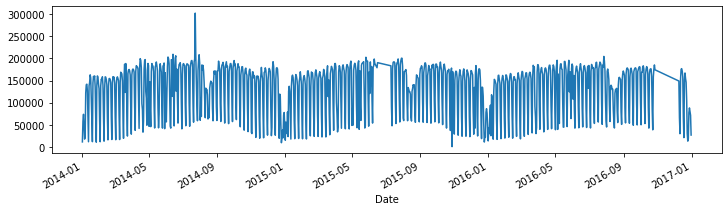

In [20]:
df_day.plot(figsize=(12,3))

Given the large gaps in data in 2015 and 2017, while there seems to be seasonal behavior on the yearly level, let's look specifically at 2014.

In [21]:
df_2014 = df_day.loc['2014-01-01':'2014-12-31']

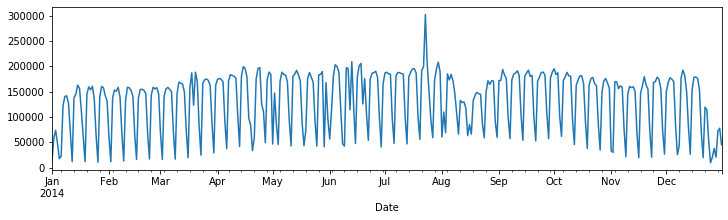

In [22]:
df_2014.plot(figsize=(12,3))

Below shows the weekly seasonality.

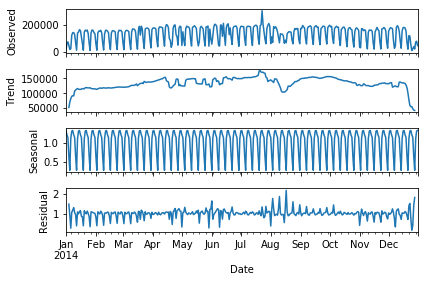

In [23]:
result = seasonal_decompose(df_2014, model='multiplicative')
result.plot()
pyplot.show()

Now we want to look at seasonality when the hour is incorporated.

In [24]:
df.head()

,ZST,FS,HHMMSS,CS,T,HH,MMSS,MM,Date
0,408,4,2112,8,0,0,2112,21,2014-01-01
1,408,3,5554,3,0,0,5554,55,2014-01-01
2,408,3,10333,3,0,1,0333,3,2014-01-01
3,408,4,14034,10,0,1,4034,40,2014-01-01
4,408,4,15724,1,0,1,5724,57,2014-01-01


In [25]:
df['Date'] += pd.to_timedelta(df.HH, unit='h')

In [4]:
df.head()

,ZST,T,ST,FZG_NR,FS,SPEED,LENTH,CS,CSF,GW_TOT,...,W5_6,W6_7,W7_8,W8_9,W9_10,Head,HEADx,GAP,CLASS,Date
0,408,0,0,0,4,7700,833,8,0,4740,...,0,0,0,0,0,33932,85.1,84.9,0,2014-01-01 00:21:12
1,408,0,0,0,3,11400,475,3,0,3920,...,0,0,0,0,0,34054,99.9,99.9,0,2014-01-01 00:55:54
2,408,0,0,0,3,10600,505,3,0,3790,...,0,0,0,0,0,34090,99.9,99.9,0,2014-01-01 01:03:33
3,408,0,0,0,4,9900,1471,10,0,23870,...,0,0,0,0,0,34286,48.7,48.6,12,2014-01-01 01:40:34
4,408,0,0,0,4,9900,1004,1,0,10040,...,0,0,0,0,0,34393,1.6,1.4,11,2014-01-01 01:57:24


In [26]:
df_day_hour = df.groupby('Date', as_index=True).MM.agg('sum')

In [27]:
df_2014_hour = df_day_hour.loc['2014-01-01 00:00:00':'2014-12-31 23:00:00']

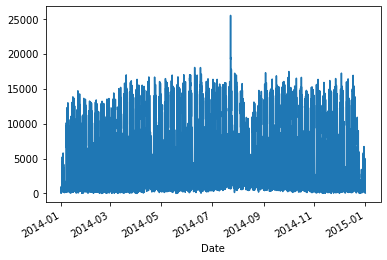

In [28]:
df_2014_hour.plot()

Below shows the 2014 seasonality by day. First it is necessary to remove any holidays or sundays. Sundays can easily be removed with the datetime and the holidays are taking from a list of Ticino holidays.

In [26]:
holidays = ['2014-01-01', '2014-01-06', '2014-03-19', '2014-04-21', '2014-05-01', '2014-05-29', '2014-06-09', '2014-06-19', 
            '2014-06-29', '2014-08-01', '2014-08-15', '2014-11-01', '2014-12-07', '2014-12-25', '2014-12-26']

In [33]:
df_2014_hour.shape

(8755,)

In [35]:
df_2014_weekdays = df_2014_hour.loc[~(df_2014_hour.index.floor('D').isin(holidays))]

In [37]:
df_2014_weekdays = df_2014_weekdays[df_2014_weekdays.index.weekday!=(5 or 6)]

In [38]:
df_2014_weekdays.shape

(7171,)

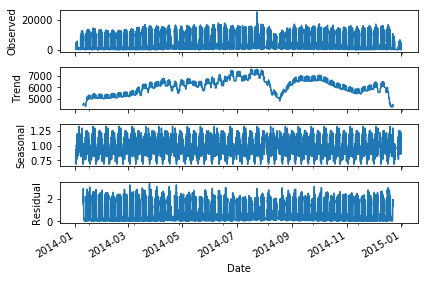

In [39]:
result = seasonal_decompose(df_2014_weekdays, model='multiplicative', freq=300)
result.plot()
pyplot.show()

Looking at a single month, March

In [40]:
df_2014_march_week = df_2014_weekdays.loc['2014-03-01 00:00:00':'2014-03-31 23:00:00']

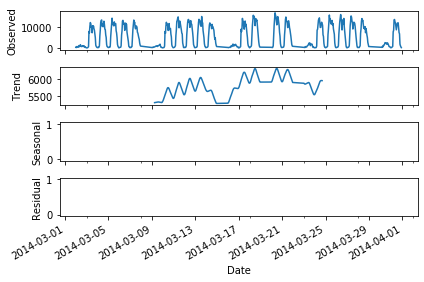

In [41]:
result = seasonal_decompose(df_2014_march, model='multiplicative', freq=300)
result.plot()
pyplot.show()

In [43]:
df_2014_week = df_2014_weekdays.loc['2014-03-24 00:00:00':'2014-03-28 23:00:00']

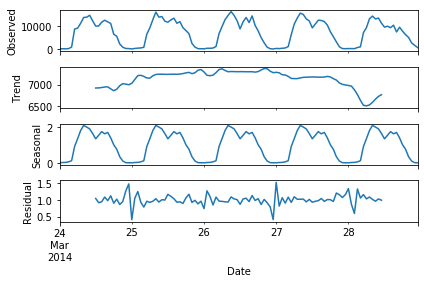

In [45]:
result = seasonal_decompose(df_2014_week, model='multiplicative')
result.plot()
pyplot.show()

### Truck Weight Seasonality

This section will explore if there is any seasonality with the truck weight/number of trucks within a given time span.

In [29]:
df_weight = df[['FS', 'GW_TOT', 'Date']]

In [40]:
df_weight['GW_TOT'] = df_weight['GW_TOT']/1000

C:\Users\Isabelle\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
df_weight['Date_h'] = df_weight['Date'].dt.round('H')

C:\Users\Isabelle\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
df_weight.head()

,FS,GW_TOT,Date,Date_h,Date_d
0,4,4.74,2014-01-01 00:21:12,2014-01-01 00:00:00,2014-01-01
1,3,3.92,2014-01-01 00:55:54,2014-01-01 01:00:00,2014-01-01
2,3,3.79,2014-01-01 01:03:33,2014-01-01 01:00:00,2014-01-01
3,4,23.87,2014-01-01 01:40:34,2014-01-01 02:00:00,2014-01-01
4,4,10.04,2014-01-01 01:57:24,2014-01-01 02:00:00,2014-01-01


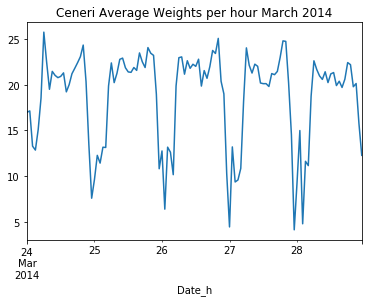

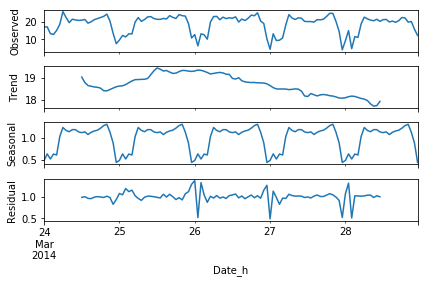

In [50]:
import matplotlib.pyplot as plt
from matplotlib.ticker import Formatter

#Split the lanes
lanes = [1, 2, 3 ,4]

#df_w_lane = df_w_lane.groupby('Date_h').GW_TOT.mean()

#df_2014_weekdays = df_2014_hour.loc[~(df_2014_hour.index.floor('D').isin(holidays))]
#df_2014_weekdays = df_2014_weekdays[df_2014_weekdays.index.weekday!=(5 or 6)]

#for lane in lanes:
#df_w_lane = df_weight.loc[df_weight['FS'] == lane]

#times = pd.to_datetime(df_weight.Date)
#df_weight_hour = df_weight.groupby([times.dt.day, times.dt.hour]).GW_TOT.mean()

df_weight_hour = df_weight.groupby('Date_h').GW_TOT.mean()
df_2014_weight = df_weight_hour.loc['2014-03-24 00:00:00':'2014-03-28 23:00:00']
df_2014_weekdays = df_2014_weight.loc[~(df_2014_weight.index.floor('D').isin(holidays))] #Eliminate holidays
df_2014_weekdays = df_2014_weekdays[df_2014_weekdays.index.weekday!=(5 or 6)] #Eliminate weekends
df_2014_weight.plot(title="{} Average Weights per hour March 2014".format(Station))
plt.show()
result = seasonal_decompose(df_2014_weight, model='multiplicative')
result.plot()
pyplot.show()
    

In [49]:
df_weight_hour

Date  Date
1     0       10.036942
      1       12.683153
      2       12.622765
      3       12.853024
      4       14.301154
                ...    
31    19      18.857776
      20      17.964721
      21      13.521024
      22       9.632803
      23       9.232533
Name: GW_TOT, Length: 744, dtype: float64

In [44]:
df_weight['Date_d'] = df_weight['Date'].dt.round('D')

C:\Users\Isabelle\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [52]:
from matplotlib.pyplot import figure


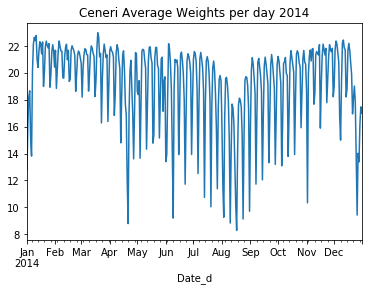

<Figure size 576x432 with 0 Axes>

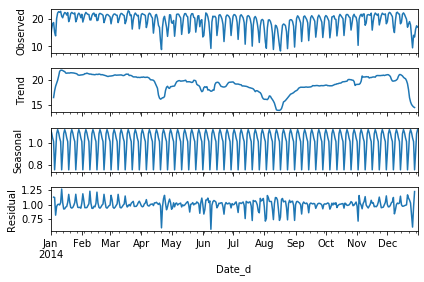

In [53]:

df_weight_day = df_weight.groupby('Date_d').GW_TOT.mean()
df_2014_weight = df_weight_day.loc['2014-01-01 00:00:00':'2014-12-31 23:00:00']
df_2014_weekdays = df_2014_weight.loc[~(df_2014_weight.index.floor('D').isin(holidays))] #Eliminate holidays
df_2014_weekdays = df_2014_weekdays[df_2014_weekdays.index.weekday!=(5 or 6)] #Eliminate weekends
df_2014_weight.plot(title="{} Average Weights per day 2014".format(Station))
plt.show()
figure(figsize=(8, 6))
result = seasonal_decompose(df_2014_weight, model='multiplicative')
result.plot()
pyplot.show()


In [87]:
df_count.head()

,FS,GW_TOT,CLASS,ZST,LENTH,CS,Date
0,4,3.50,0,408,674,5,2011-01-01 00:54:14
1,4,5.27,0,408,839,8,2011-01-01 00:54:48
2,4,19.28,12,408,1429,10,2011-01-01 02:43:02
3,4,4.40,0,408,742,5,2011-01-01 02:54:33
4,4,4.09,0,408,819,8,2011-01-01 03:12:30


In [154]:
df_count = pd.read_csv('{}Data/2011_2019_datetime.csv'.format(Station), index_col=0, parse_dates=['Date'])    

C:\Users\Isabelle\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [155]:
df_count['GW_TOT'] = df_count['GW_TOT']/1000

In [156]:
times = pd.to_datetime(df_count.Date)
df_year_hour = df_count.groupby([times.dt.year, times.dt.hour]).GW_TOT.mean()


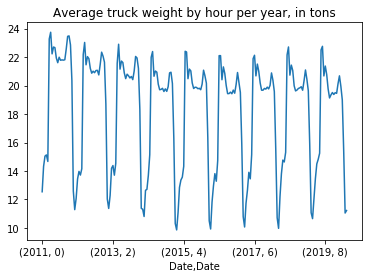

In [157]:
df_year_hour.plot(title="Average truck weight by hour per year, in tons")

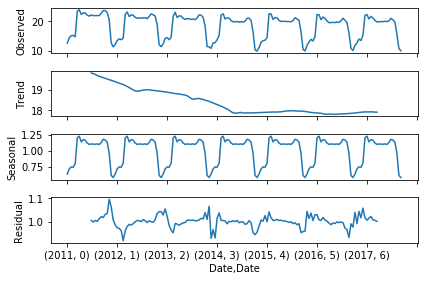

In [73]:
result = seasonal_decompose(df_year_hour, model='multiplicative', freq=24)
result.plot()
pyplot.show()

In [158]:
df_count_year = df_count.groupby([times.dt.year, times.dt.hour]).Date.count()

In [159]:
df_count_year

Date  Date
2011  0        6136
      1        6712
      2        6096
      3        6814
      4       10439
              ...  
2019  19      43573
      20      28327
      21      16726
      22      10515
      23       7845
Name: Date, Length: 216, dtype: int64

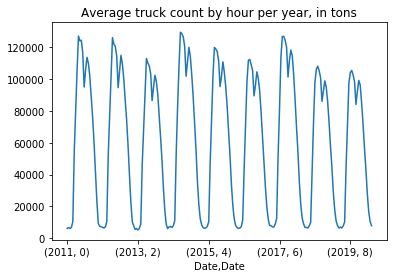

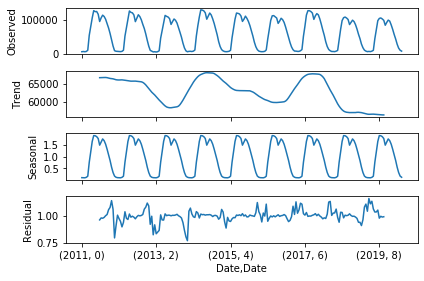

In [160]:
df_count_year.plot(title="Average truck count by hour per year, in tons")
result = seasonal_decompose(df_count_year, model='multiplicative', freq=24)
result.plot()
pyplot.show()

In [161]:
#Get the non-zero days per year
days = df_count.Date.dt.date.unique()
years = pd.to_datetime(days).to_series() \
            .groupby(pd.Grouper(freq='Y')) \
            .count()

In [162]:
years.index = years.index.year

In [163]:
years.index.name = "Year"

In [164]:
df_count_year.index.names = ['Year', 'Hour']
df_count_year

Year  Hour
2011  0        6136
      1        6712
      2        6096
      3        6814
      4       10439
              ...  
2019  19      43573
      20      28327
      21      16726
      22      10515
      23       7845
Name: Date, Length: 216, dtype: int64

In [172]:
df_count['Year'] = df.Date.dt.year

In [173]:
df_merged = pd.merge(years.rename('total_days'), pd.DataFrame(df_count), on="Year", how="right")

In [174]:
df_merged.head()

,Year,total_days,FS,GW_TOT,CLASS,ZST,LENTH,CS,Date
0,2011.0,365.0,4,3.50,0,408,674,5,2011-01-01 00:54:14
1,2011.0,365.0,4,5.27,0,408,839,8,2011-01-01 00:54:48
2,2011.0,365.0,4,19.28,12,408,1429,10,2011-01-01 02:43:02
3,2011.0,365.0,4,4.40,0,408,742,5,2011-01-01 02:54:33
4,2011.0,365.0,4,4.09,0,408,819,8,2011-01-01 03:12:30


In [179]:
df_merged['Date_d'] = df_merged.Date.dt.date

In [181]:
df_merged = df_merged.groupby([times.dt.year, times.dt.hour]).agg({'Date':'count', 'Date_d':'nunique'}) 

In [184]:
df_merged.head()

Date  Date_d  norm_count
Date Date                           
2011 0      6136     365   16.810959
     1      6712     365   18.389041
     2      6096     364   16.747253
     3      6814     365   18.668493
     4     10439     365   28.600000

In [183]:
df_merged['norm_count'] = df_merged.Date/df_merged.Date_d

In [166]:
df_merged = pd.merge(years.rename('total_days'), pd.DataFrame(df_count_year), on="Year", how="right")

In [167]:
df_merged['Count_norm'] = df_merged['Date']/df_merged['total_days']

In [169]:
df_merged.Count_norm

Year
2011     16.810959
2011     18.389041
2011     16.701370
2011     18.668493
2011     28.600000
           ...    
2019    140.558065
2019     91.377419
2019     53.954839
2019     33.919355
2019     25.306452
Name: Count_norm, Length: 216, dtype: float64

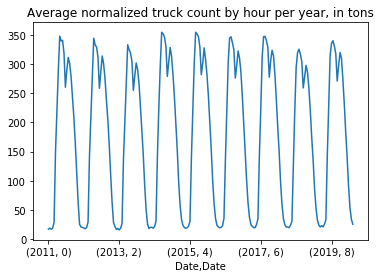

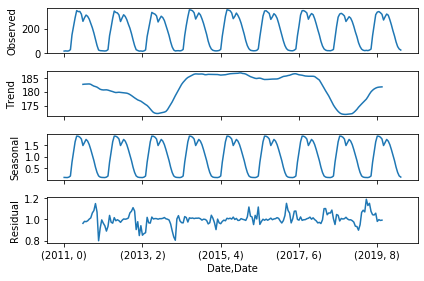

In [185]:
df_merged.norm_count.plot(title="Average normalized truck count by hour per year, in tons")
result = seasonal_decompose(df_merged.norm_count, model='multiplicative', freq=24)
result.plot()
pyplot.show()

In [194]:
df_yearly_count = df_count.groupby([times.dt.year]).Date.count()
df_year_nrom = df_yearly_count/years

(0, 5000)

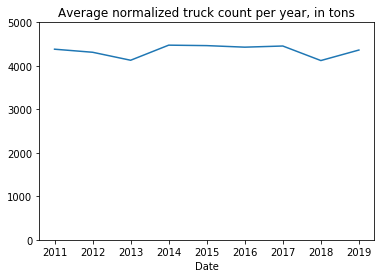

In [197]:
ax =df_year_nrom.plot(title="Average normalized truck count per year, in tons")
ax.set_ylim(0, 5000)

### Correlation

This section aims to investigate the correlation between features to see which features are correlated together, particularly with time.

In [94]:
df = pd.read_csv('{}Data/2011_2018_datetime.csv'.format(Station), index_col=0, parse_dates=['Date']) 

C:\Users\Isabelle\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [95]:
df.head()

,FS,GW_TOT,CLASS,ZST,LENTH,CS,Date
0,4,3500,0,408,674,5,2011-01-01 00:54:14
1,4,5270,0,408,839,8,2011-01-01 00:54:48
2,4,19280,12,408,1429,10,2011-01-01 02:43:02
3,4,4400,0,408,742,5,2011-01-01 02:54:33
4,4,4090,0,408,819,8,2011-01-01 03:12:30


In [97]:
df['weekday'] = df.Date.dt.weekday

In [99]:
df['hour'] = df.Date.dt.hour

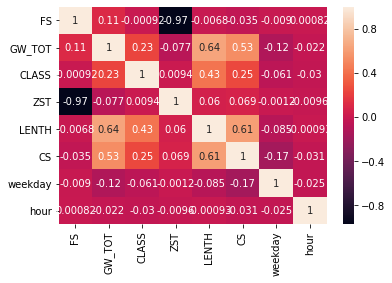

In [100]:
import matplotlib.pyplot as plt
import seaborn as sn

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()